In [1]:
import os
import cv2
import numpy as np
import torch
import random

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import matplotlib.pyplot as plt


In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def compute_metrics(pred, target, threshold=0.5):
    """
    Compute IoU and Dice for binary masks.
    """
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    # Check if both prediction and target are empty.
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice



In [7]:
dataset_path = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")

In [8]:
sam2_checkpoint = "/home/dmatveev/workdir/rosneft_segmentation/models/sam2.1_hiera_base_plus.pt"  # Path to model weights
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"       # путь к конфигу с префиксом file://

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [9]:
all_files = sorted(os.listdir(seismic_dir))
val_files = all_files[-30:]

File: 972.dat, IoU: 0.0330, Dice: 0.0638


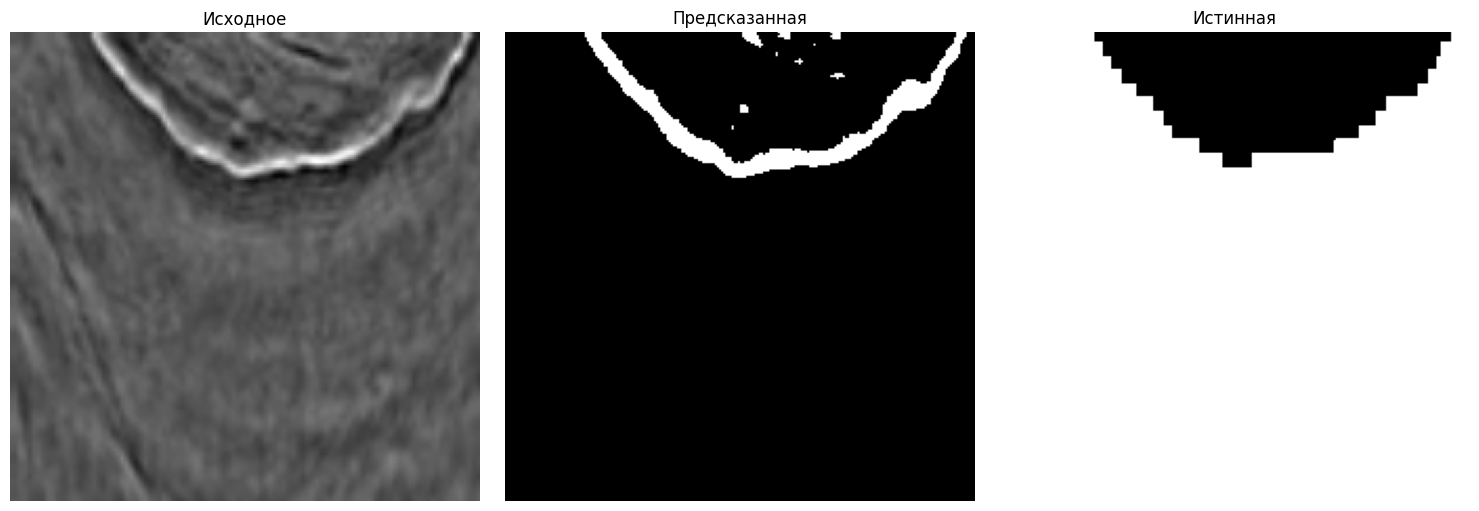

File: 973.dat, IoU: 0.2784, Dice: 0.4356


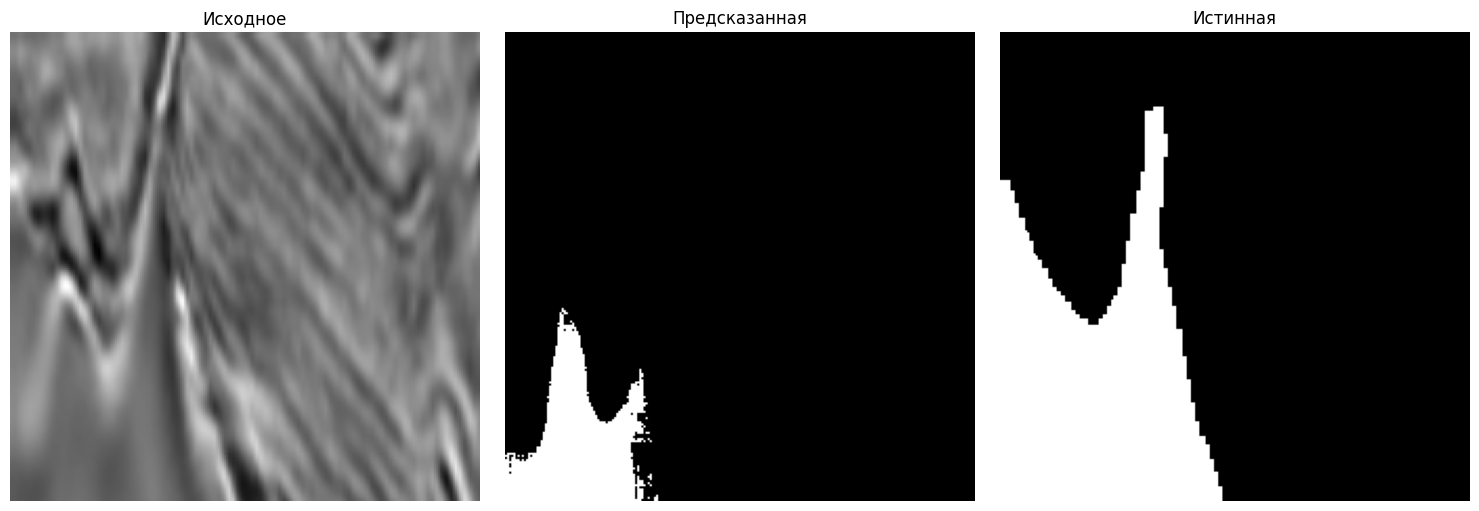

File: 974.dat, IoU: 1.0000, Dice: 1.0000


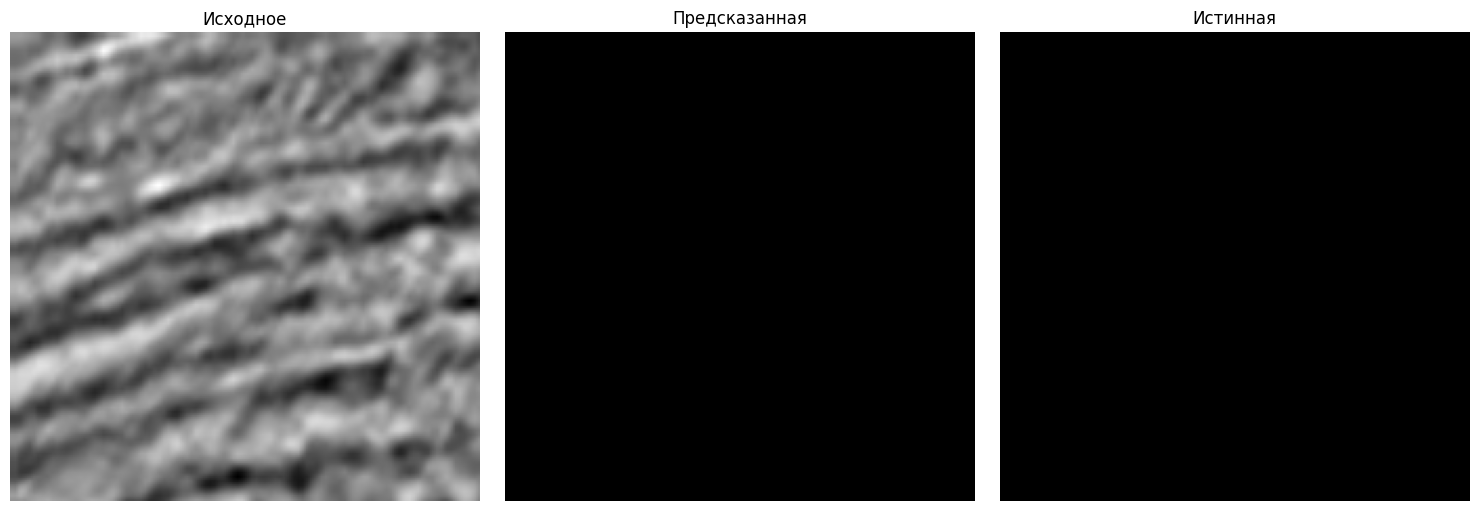

File: 975.dat, IoU: 0.4574, Dice: 0.6277


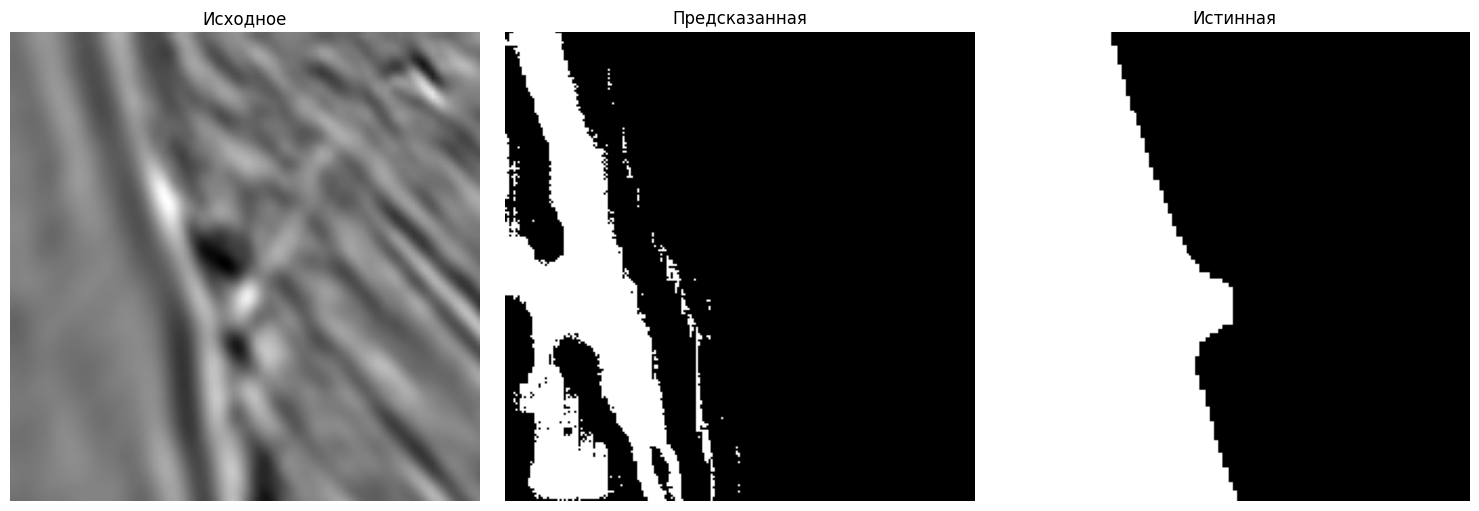

File: 976.dat, IoU: 0.0000, Dice: 0.0000


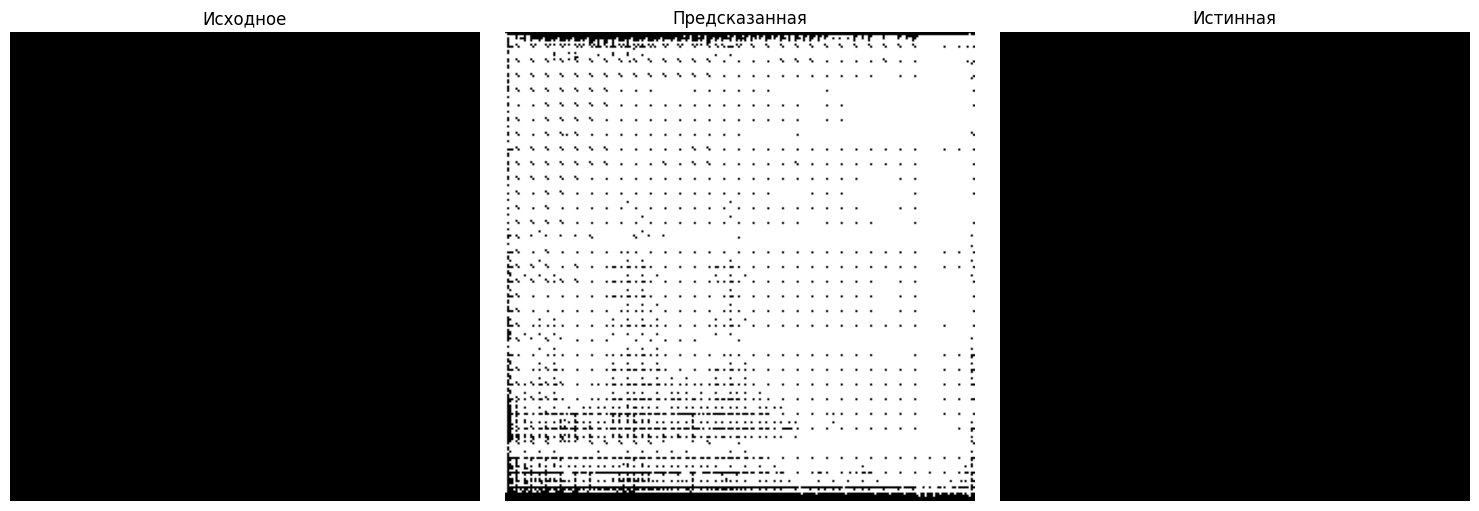

File: 977.dat, IoU: 1.0000, Dice: 1.0000


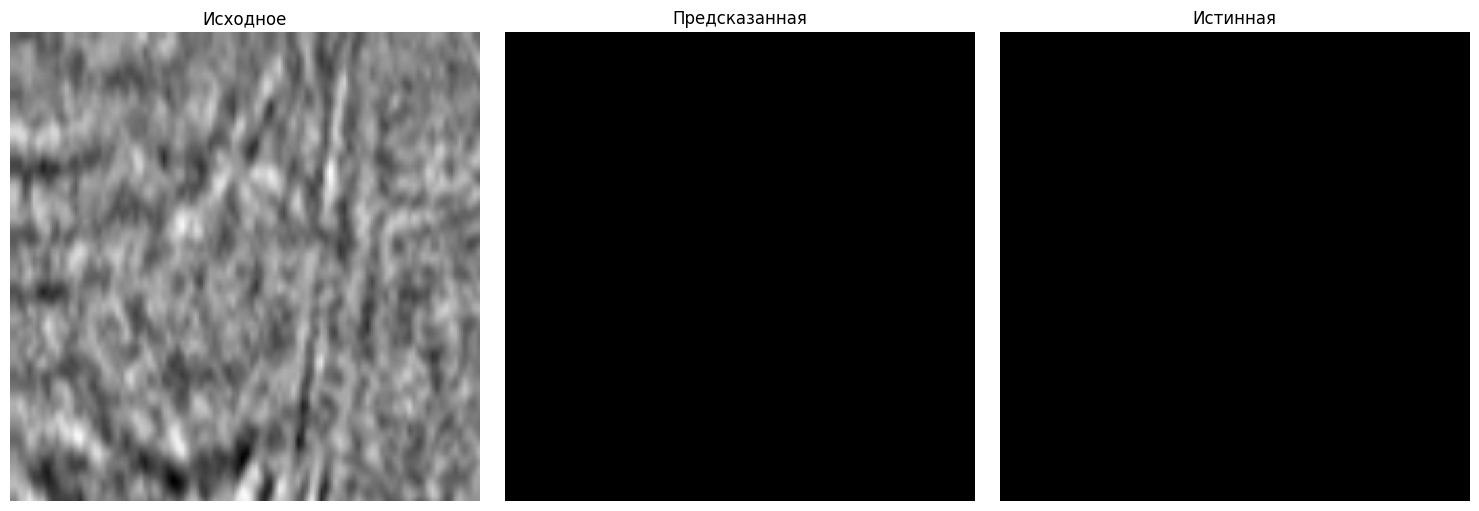

File: 978.dat, IoU: 0.8292, Dice: 0.9066


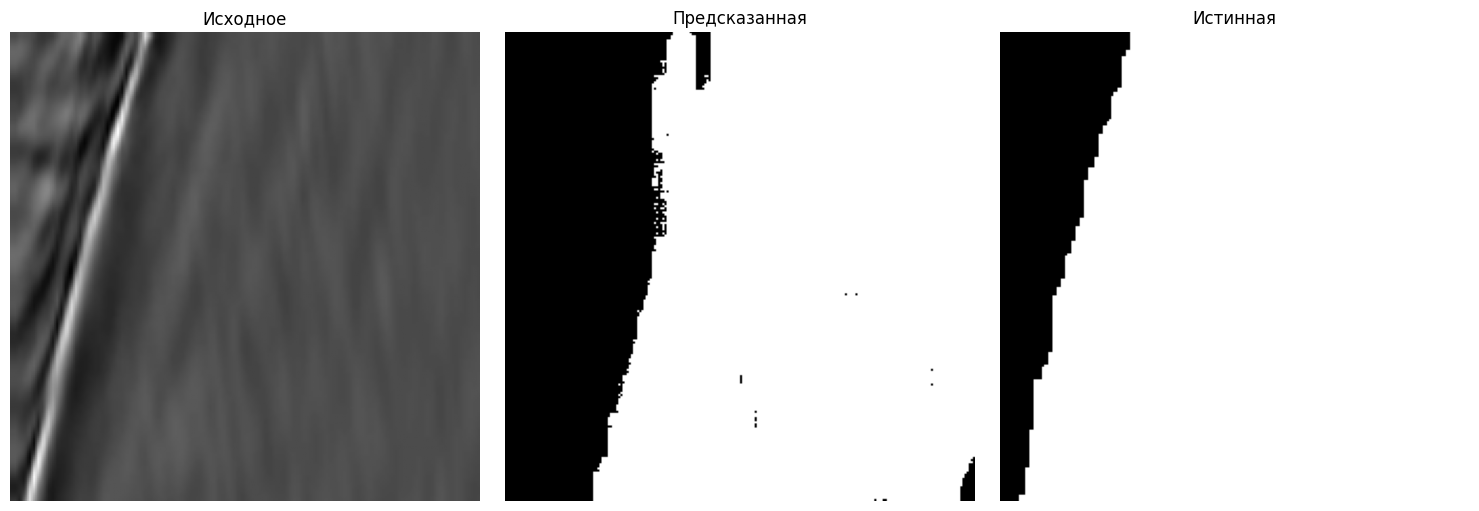

File: 979.dat, IoU: 0.7290, Dice: 0.8432


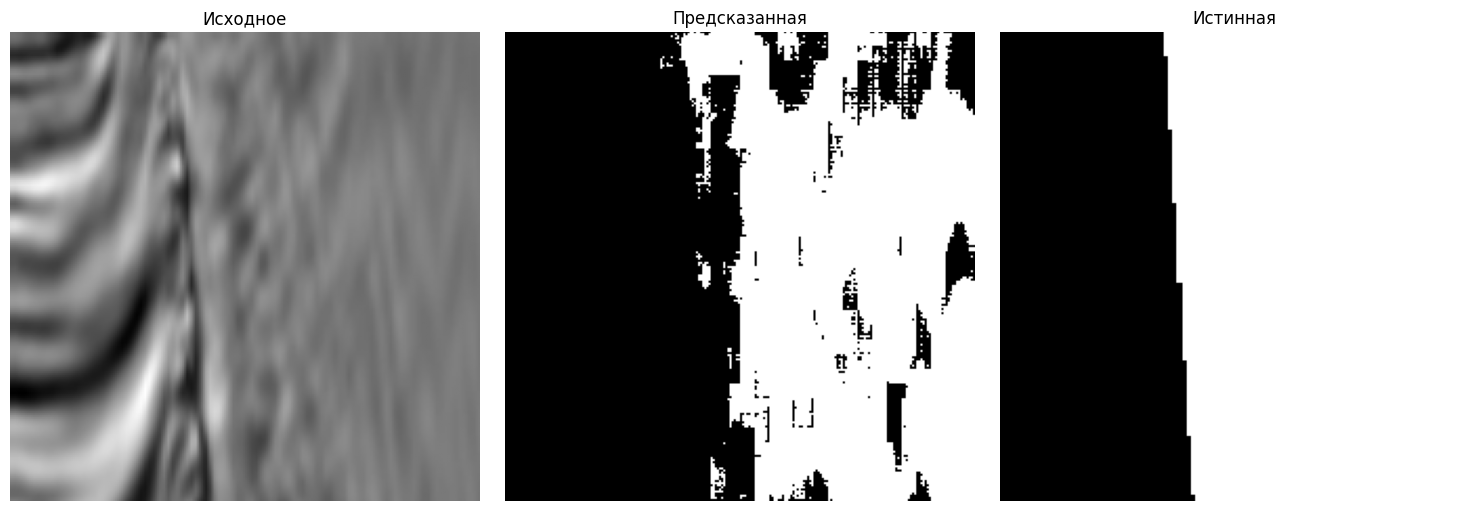

File: 98.dat, IoU: 0.0000, Dice: 0.0000


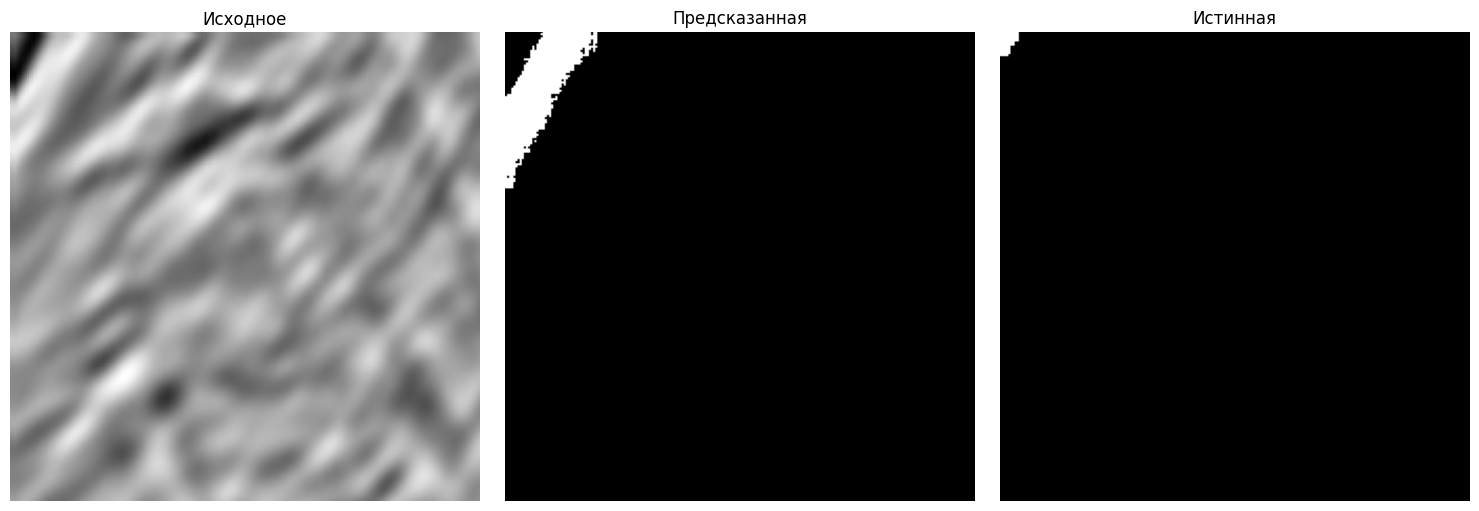

File: 980.dat, IoU: 0.8033, Dice: 0.8909


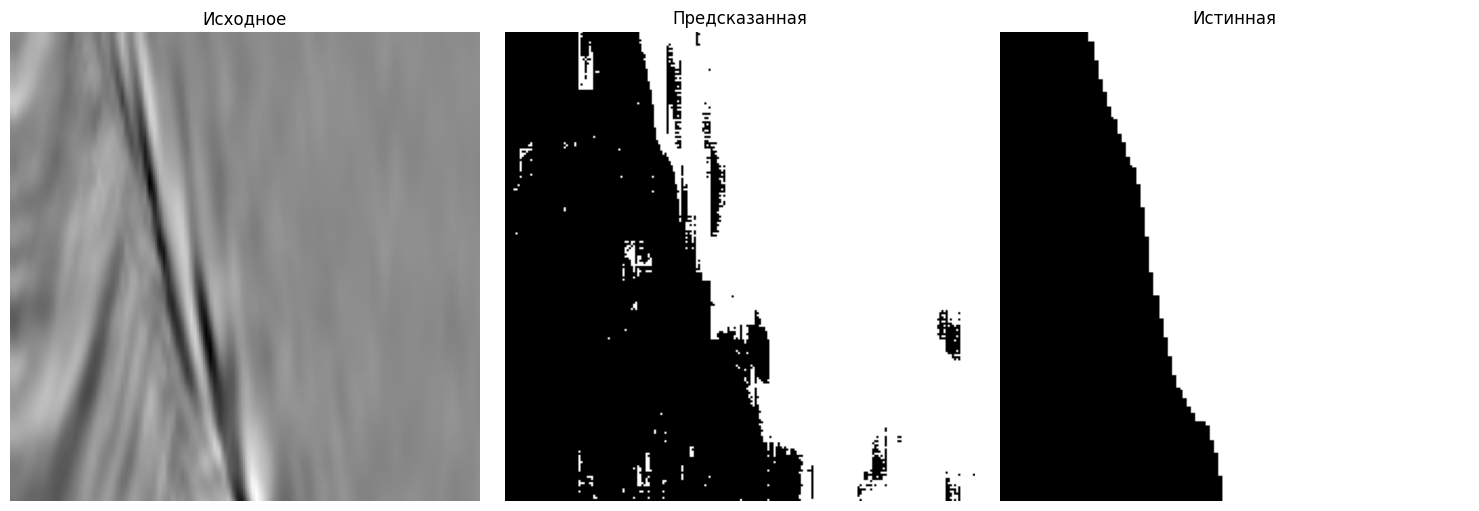

File: 981.dat, IoU: 0.5320, Dice: 0.6945


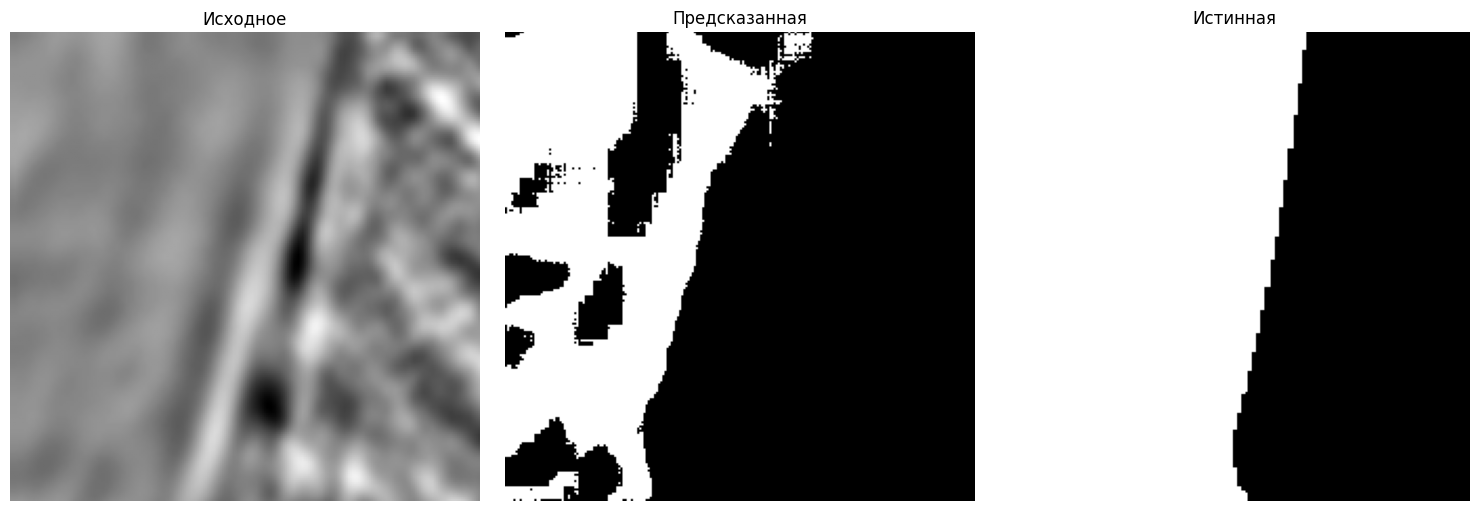

File: 982.dat, IoU: 0.2254, Dice: 0.3679


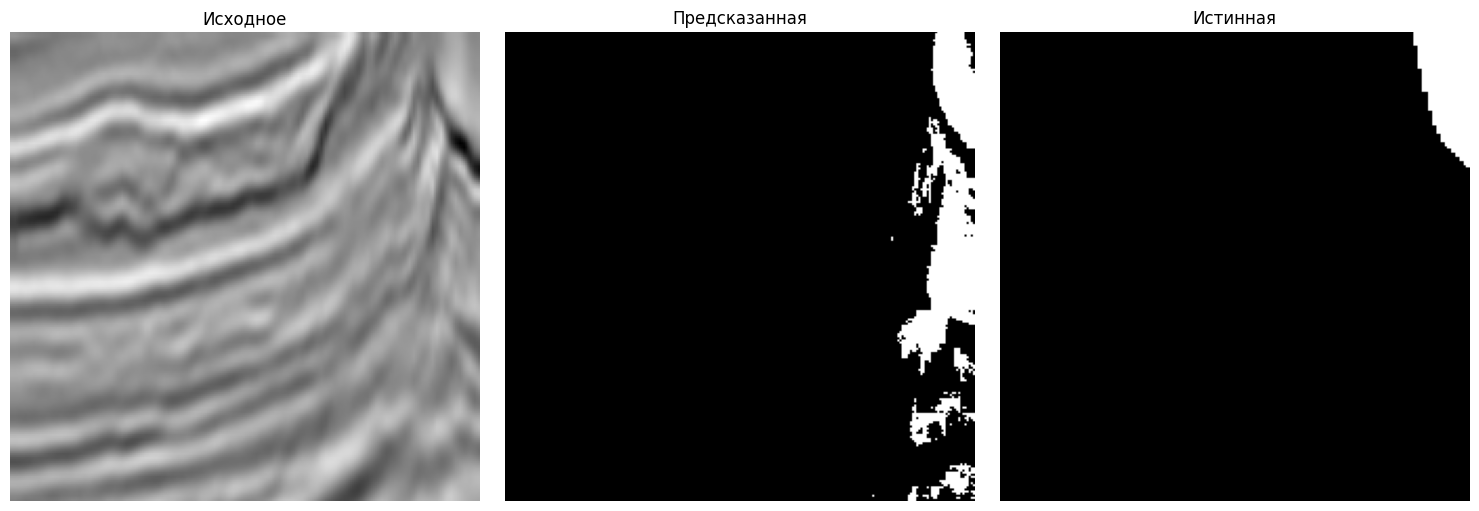

File: 983.dat, IoU: 1.0000, Dice: 1.0000


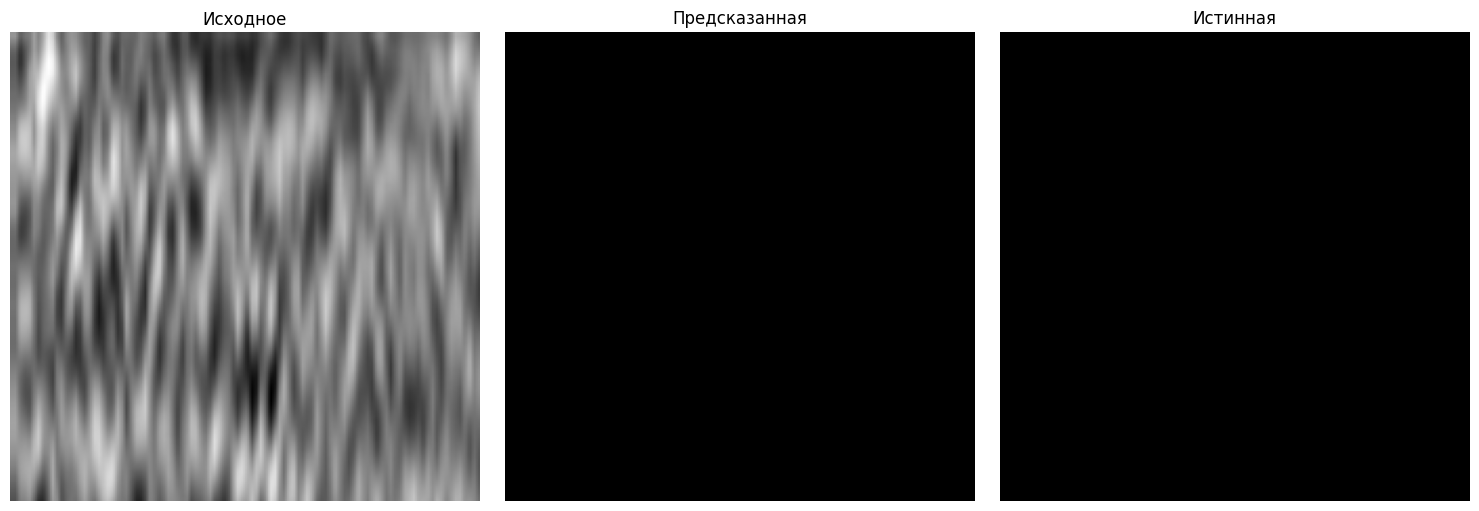

File: 984.dat, IoU: 0.5891, Dice: 0.7415


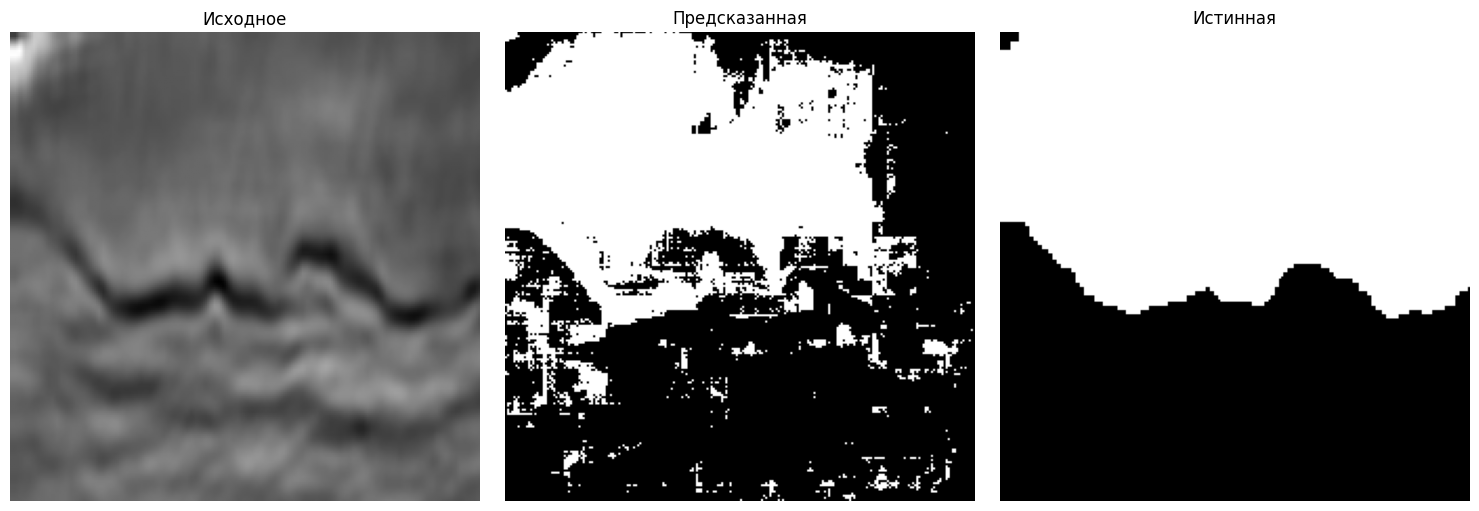

File: 985.dat, IoU: 1.0000, Dice: 1.0000


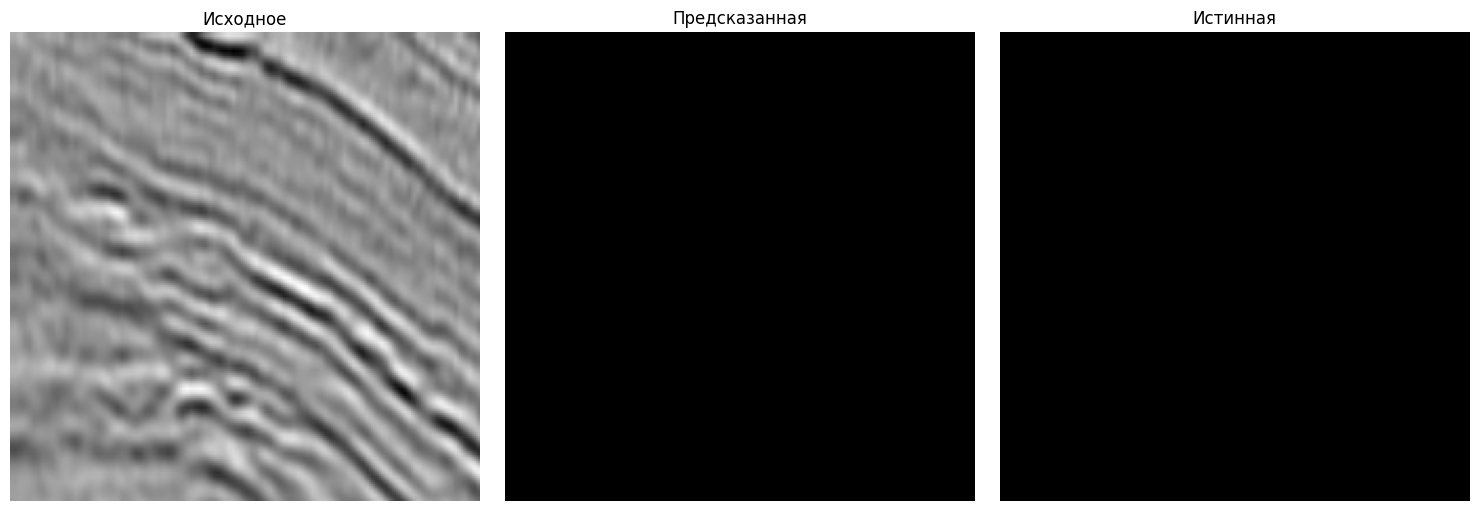

File: 986.dat, IoU: 1.0000, Dice: 1.0000


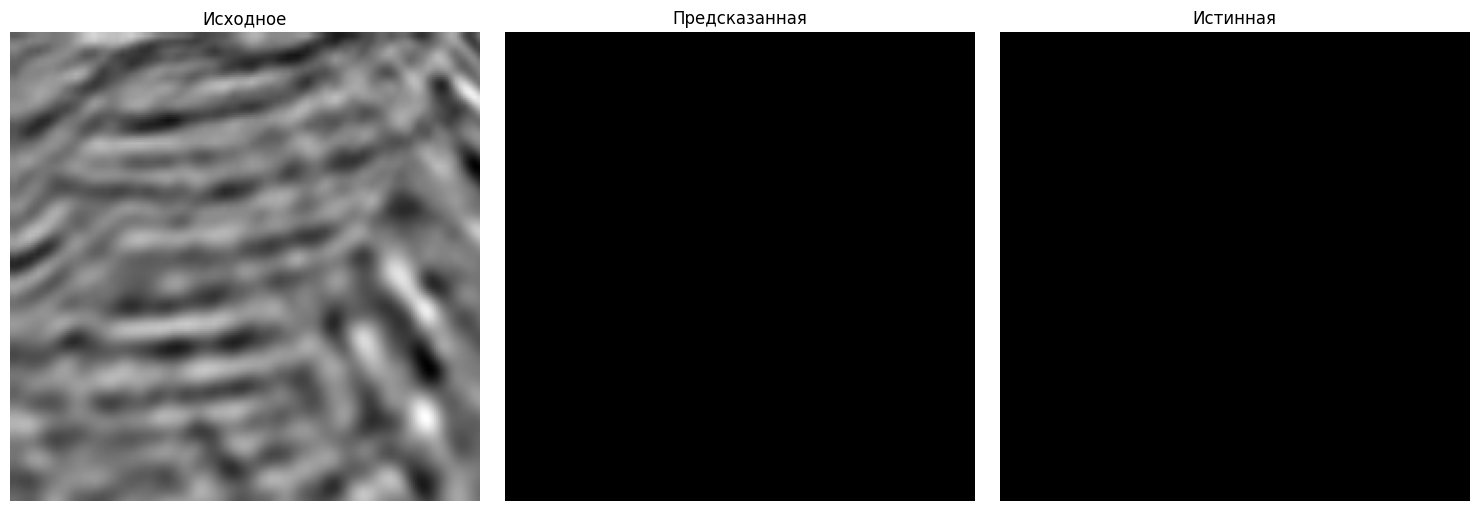

File: 987.dat, IoU: 0.6073, Dice: 0.7557


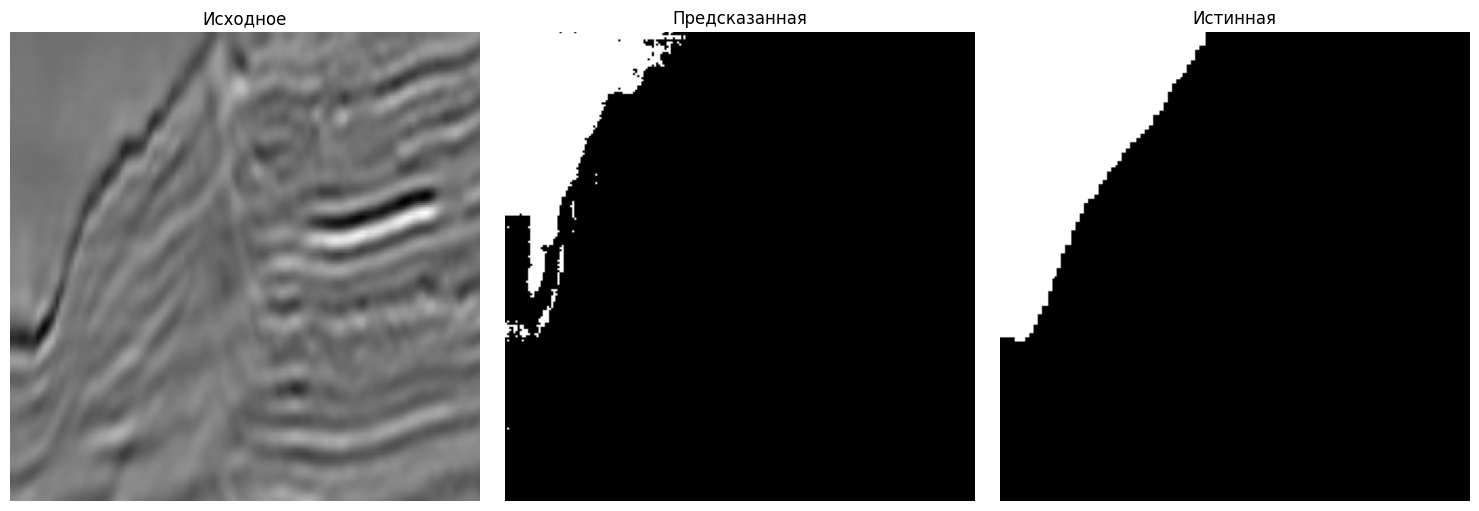

File: 988.dat, IoU: 1.0000, Dice: 1.0000


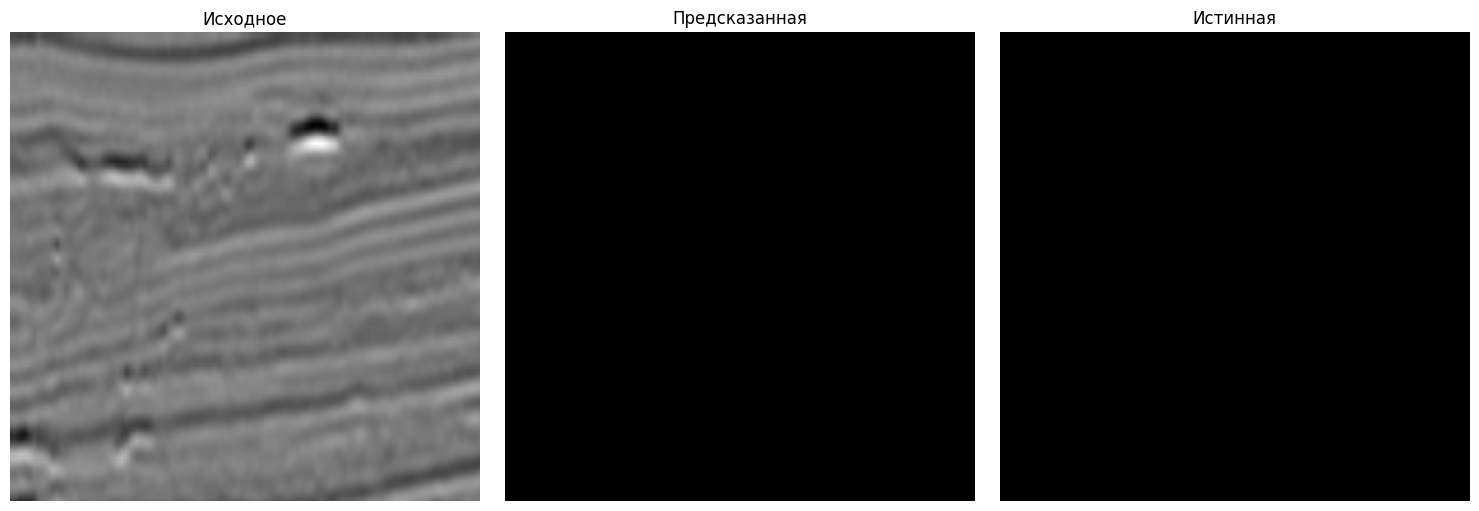

File: 989.dat, IoU: 0.1075, Dice: 0.1941


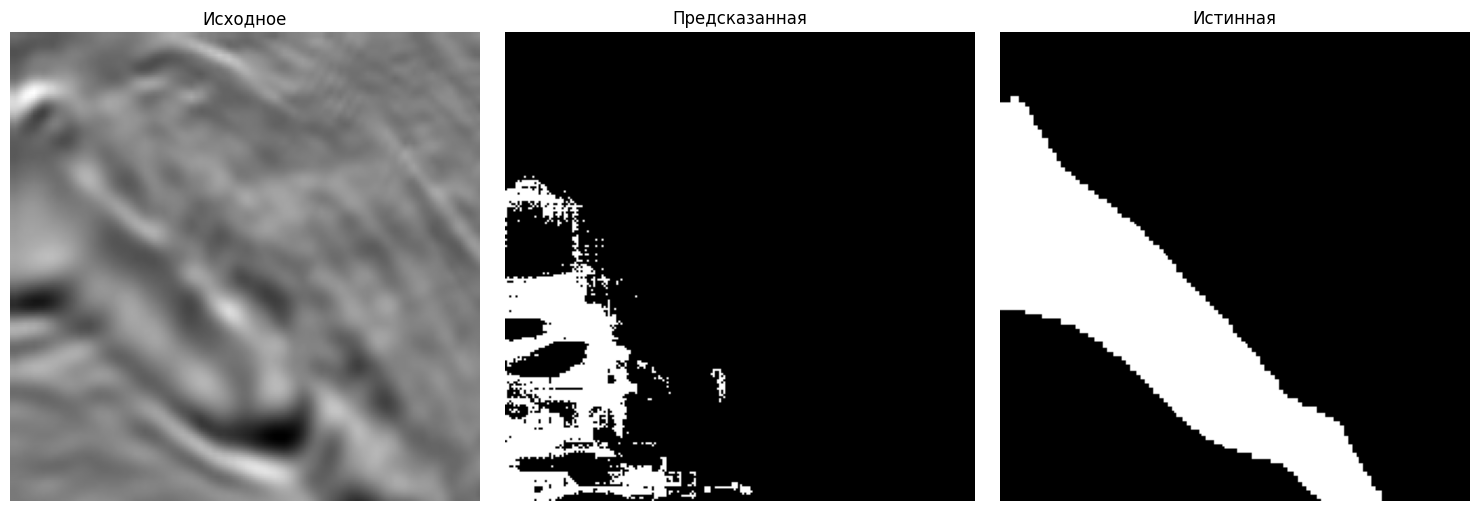

File: 99.dat, IoU: 1.0000, Dice: 1.0000


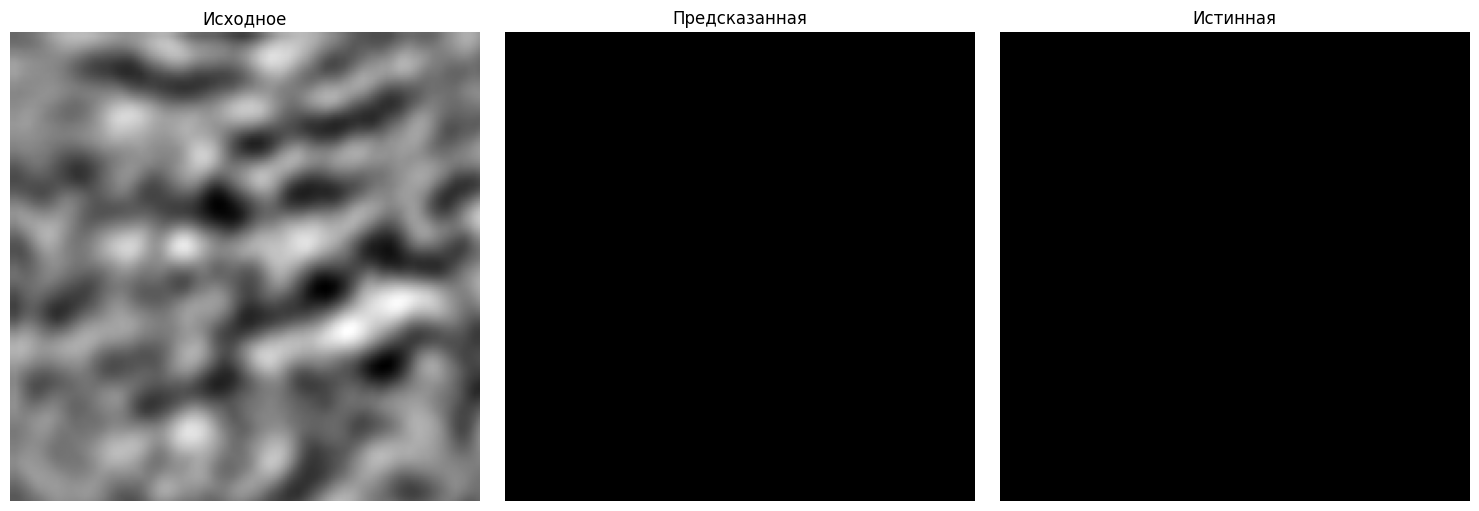

File: 990.dat, IoU: 0.0501, Dice: 0.0954


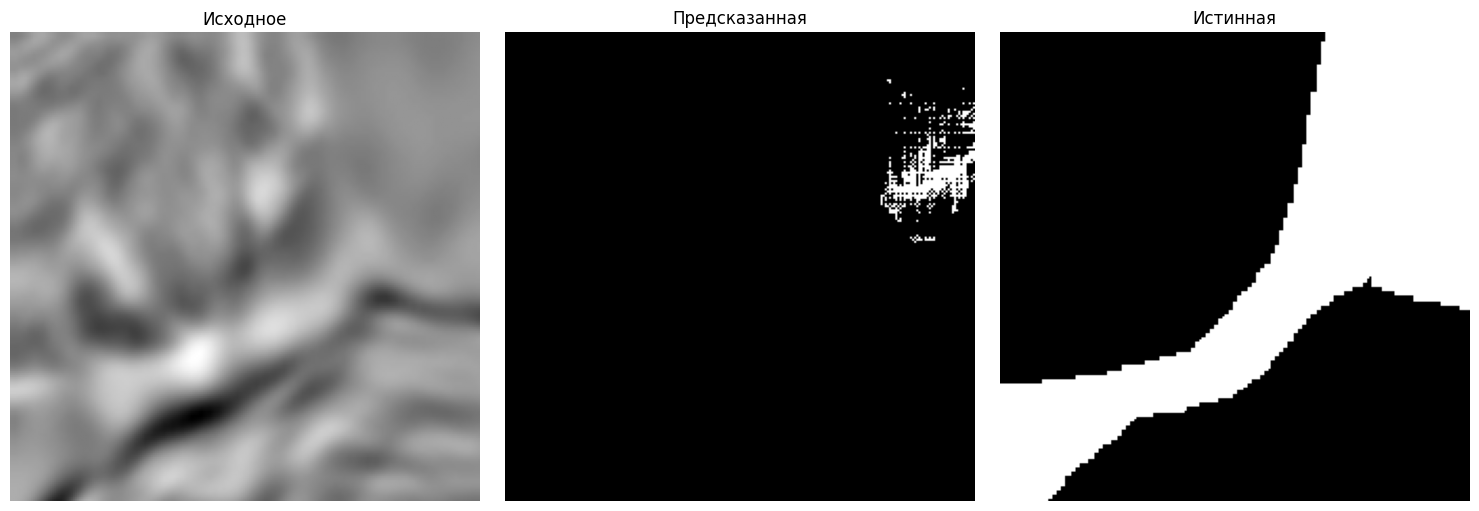

File: 991.dat, IoU: 0.4898, Dice: 0.6576


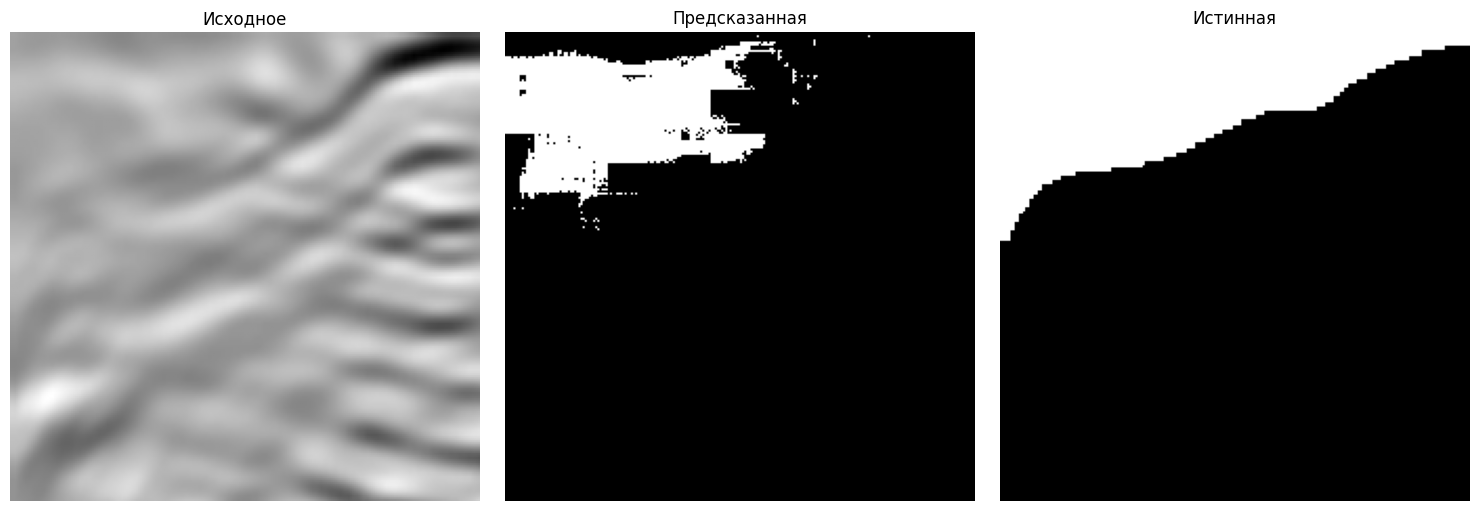

File: 992.dat, IoU: 0.3092, Dice: 0.4724


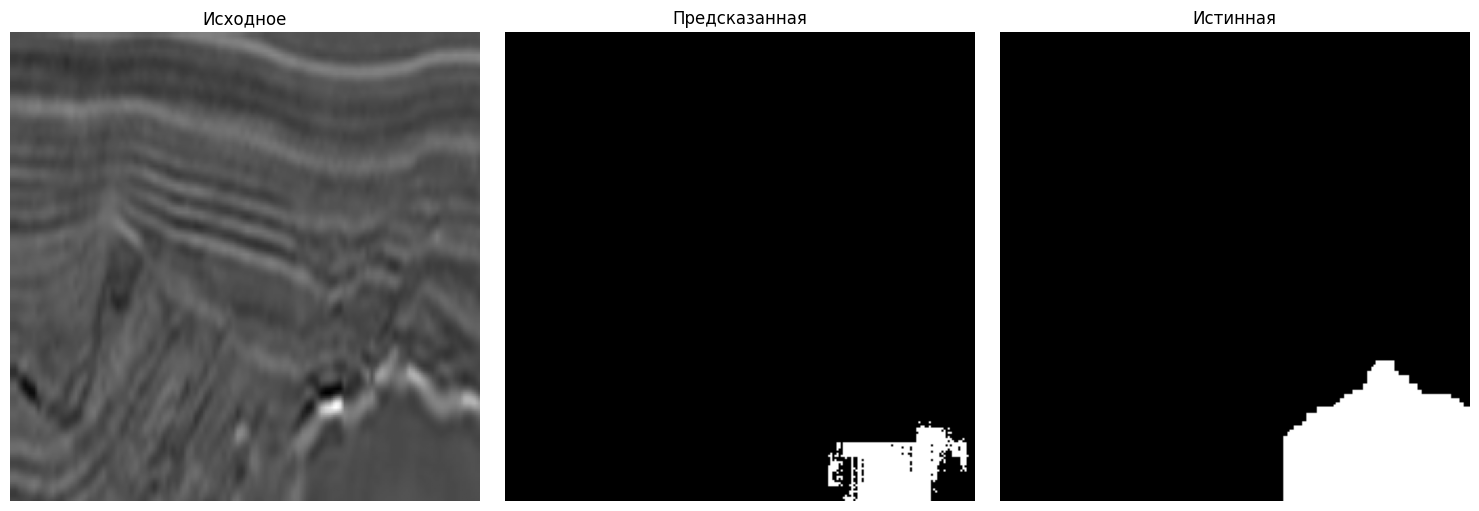

File: 993.dat, IoU: 1.0000, Dice: 1.0000


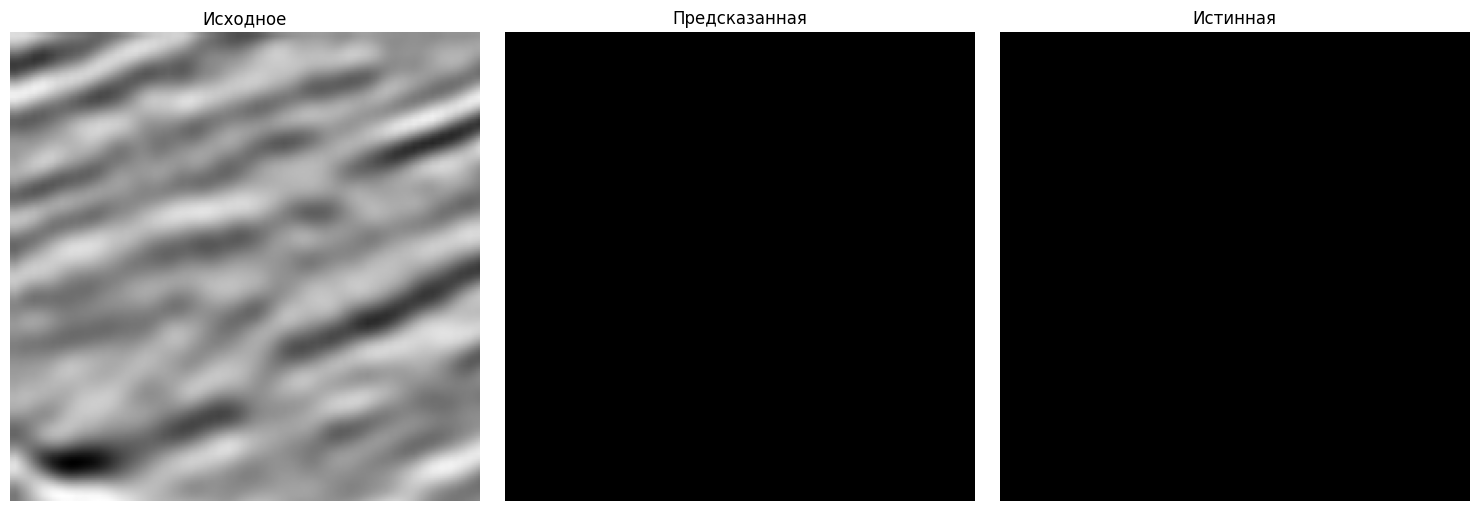

File: 994.dat, IoU: 0.4938, Dice: 0.6612


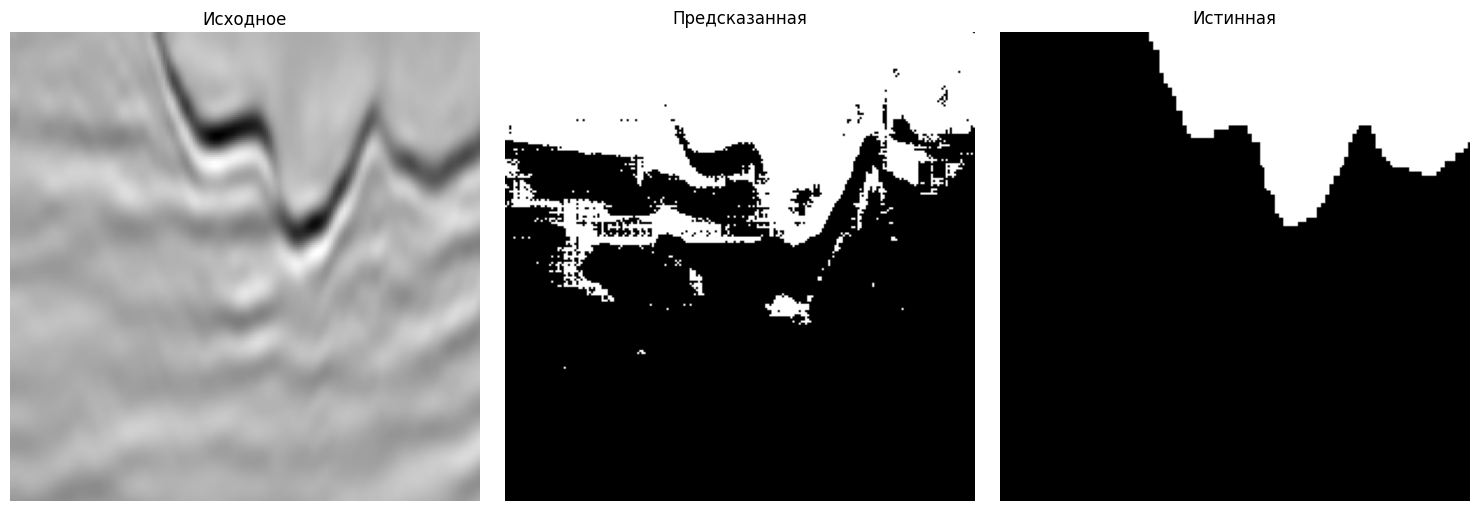

File: 995.dat, IoU: 0.0000, Dice: 0.0000


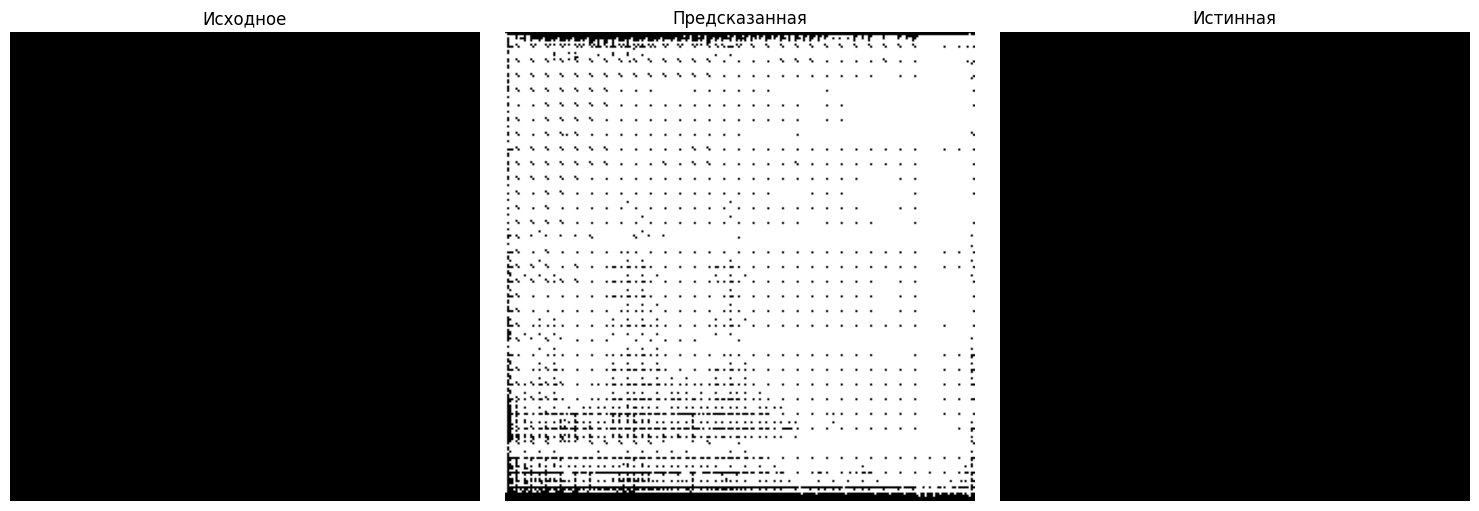

File: 996.dat, IoU: 0.3275, Dice: 0.4934


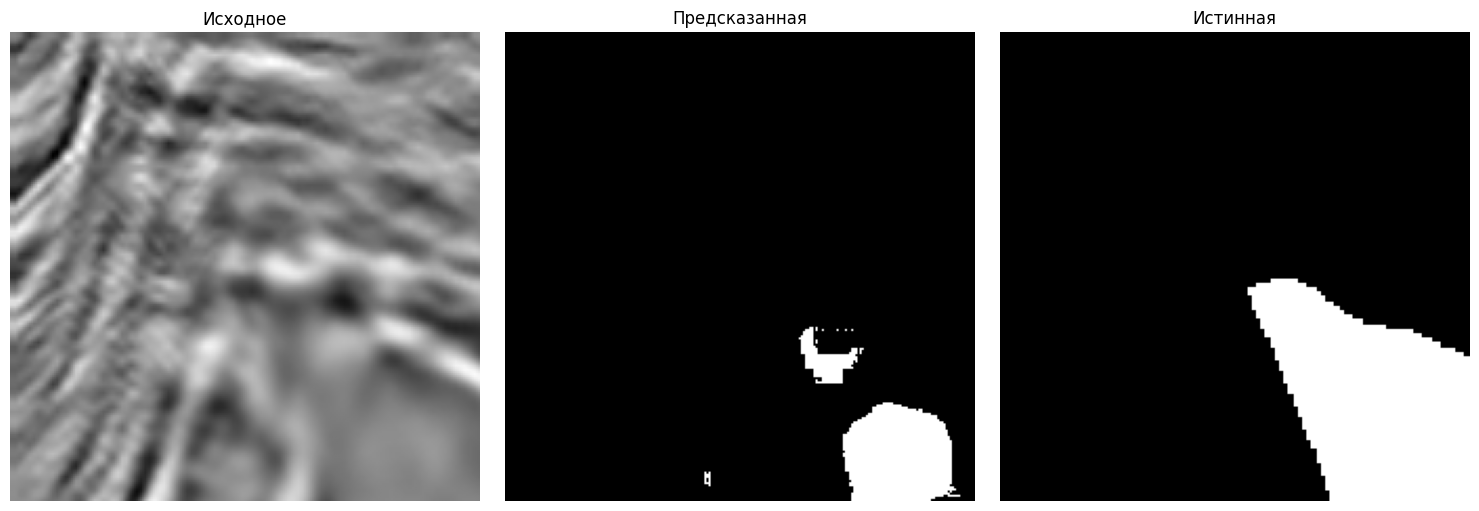

File: 997.dat, IoU: 1.0000, Dice: 1.0000


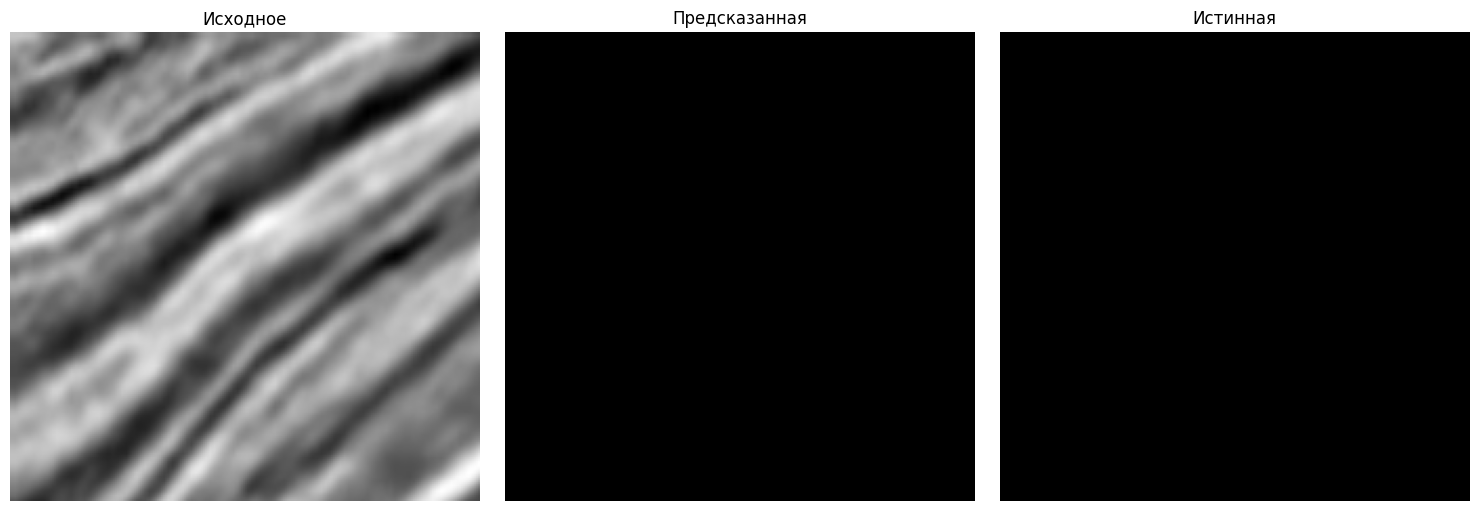

File: 998.dat, IoU: 1.0000, Dice: 1.0000


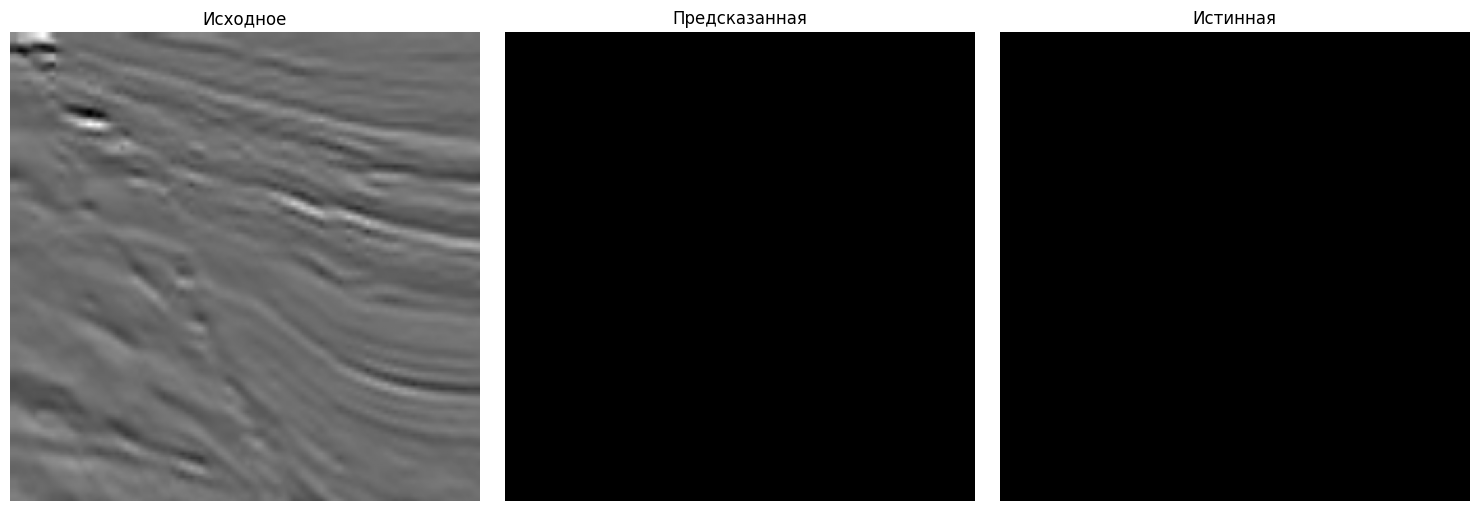

File: 999.dat, IoU: 1.0000, Dice: 1.0000


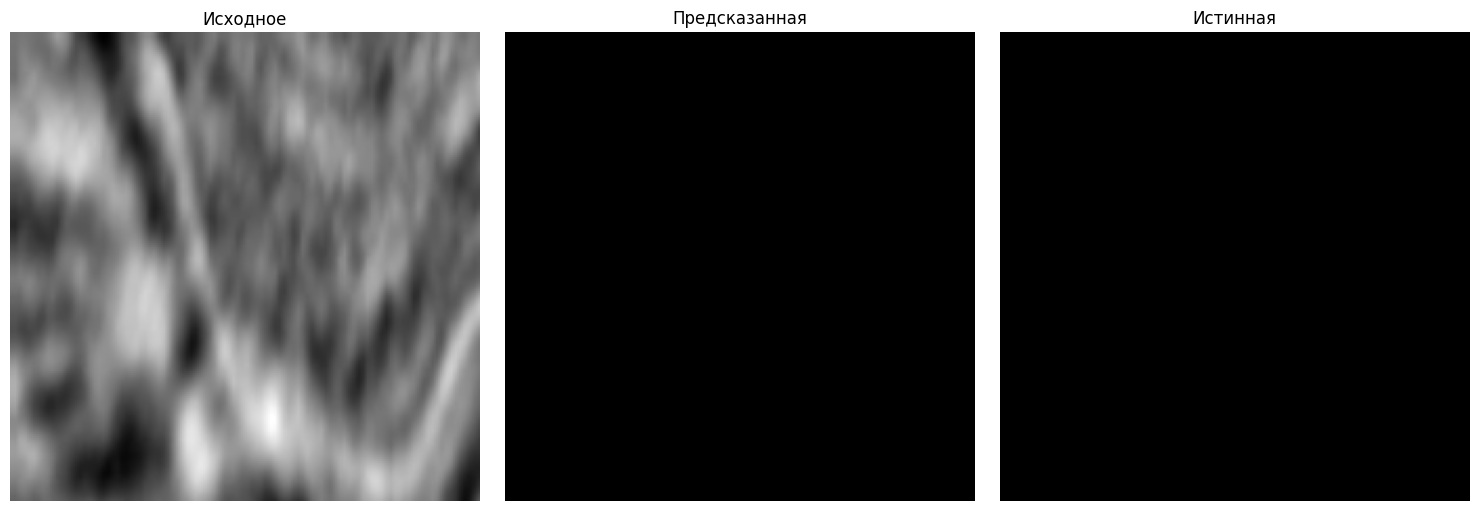

In [10]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Предполагаем, что имя файла такое же

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если исходное изображение одноканальное, дублируем канал для создания 3-канального изображения
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    predictor.set_image(seismic_img)

    # Get a random point from the ground truth mask as prompt.
    # Assumes non-zero pixels are the object of interest.
    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)
        # SAM usually expects point coordinates as (x, y) (i.e. column, row)
        prompt_point = np.array([[chosen_idx[1], chosen_idx[0]]], dtype=np.float32)
        point_label = np.array([1], dtype=np.int32)  # Positive prompt
        # Call predict with point prompt
        masks, scores, logits = predictor.predict(point_coords=prompt_point, point_labels=point_label)
    else:
        # Fallback to a prediction without prompt if no positive points found
        masks, scores, logits = predictor.predict()

    if len(masks) > 0:
        pred_mask = masks[0]
    else:
        pred_mask = np.zeros_like(label)

    # Resize predicted mask to match the label size
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))

    # Compute metrics
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)

    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Visualization: original image, predicted mask, and ground truth mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(seismic, cmap='gray')
    axes[0].set_title("Исходное")
    axes[0].axis('off')
    
    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Предсказанная")
    axes[1].axis('off')
    
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title("Истинная")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [11]:
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)

print(f"\nAverage IoU over validation set: {avg_iou:.4f}")
print(f"Average Dice coefficient over validation set: {avg_dice:.4f}")


Average IoU over validation set: 0.5954
Average Dice coefficient over validation set: 0.6634
